# Notebook illustrating retrofit cost estimation with predictive models

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from retrofit_cost_tool import (load_data, preprocess_data, load_model,
                                 train_ridge_model, train_elastic_net_model,
                                 train_random_forest_model, train_gradient_boosting_model,
                                 train_ols_model, train_glm_gamma_model,
                                 model_selection)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import numpy as np

In [3]:
# Specify the features used during training
features_string = ['seismicity_pga050', 'p_obj_dummy', 'bldg_group_dummy', 'sp_dummy', 'occup_cond', 'historic_dummy']
features_num = ['area', 'bldg_age', 'stories']

# Create a file uploader widget
file_uploader = widgets.FileUpload(
    description='Upload data file',
    accept='.csv'
)

alpha_grid = np.logspace(-3, 3, 100)
l1_ratio_grid = np.linspace(0.1, 0.9, 10)
n_estimators_grid = [100, 200, 300]
max_depth_grid = [None, 5, 10]

# Create a dictionary of model training functions
model_train_funcs = {
    'ols': (train_ols_model, ()),
    'glm_gamma': (train_glm_gamma_model, ()),
    'ridge': (train_ridge_model, (alpha_grid,)),
    'elastic_net': (train_elastic_net_model, (alpha_grid, l1_ratio_grid)),
    'random_forest': (train_random_forest_model, (n_estimators_grid, max_depth_grid)),
    'gradient_boosting': (train_gradient_boosting_model, (n_estimators_grid, max_depth_grid))
}

# Create a dropdown widget for model selection
model_selector = widgets.Dropdown(
    options=list(model_train_funcs.keys()),
    value='ridge',
    description='Select model:',
    disabled=False
)

# Create a button widget to trigger prediction
predict_button = widgets.Button(description='Make Predictions')

# Define a function to load data and make predictions
def make_predictions(file_uploader, model_selector):
    """
    Load user data, preprocess it, load a trained model, and make predictions.

    Args:
    - file_uploader (widgets.FileUpload): File uploader widget.
    - model_selector (widgets.Dropdown): Dropdown widget for model selection.

    Returns:
    - None
    """
    # Load user data
    file_path = list(file_uploader.value.keys())[0]
    with open(file_path, 'wb') as f:
        f.write(file_uploader.value[file_path]['content'])

    X_user = load_data(file_path)
    X_user, _ = preprocess_data(X_user, features_string, features_num, target=None)

    # Load the trained model
    model_name = model_selector.value
    model_path = os.path.join('..', 'models', f'{model_name}_model.pkl')
    model = load_model(model_path)

    # Make predictions
    predictions = model.predict(X_user)
    print("Predictions:")
    print(predictions)

# Define a function to handle button click
def on_button_click(b):
    make_predictions(file_uploader, model_selector)

# Link the button click to the on_button_click function
predict_button.on_click(on_button_click)

In [4]:
# Display the widgets
display(file_uploader)
display(model_selector)
display(predict_button)

FileUpload(value=(), accept='.csv', description='Upload data file')

Dropdown(description='Select model:', index=2, options=('ols', 'glm_gamma', 'ridge', 'elastic_net', 'random_fo…

Button(description='Make Predictions', style=ButtonStyle())

## Predictions with user data

In [5]:
# Example usage
print("Example usage:")
print("Load synthetic data...")
synthetic_data_path = os.path.join('..', 'data', 'synthetic_data.csv')
synthetic_data = load_data(synthetic_data_path)

Example usage:
Load synthetic data...


In [6]:
print(synthetic_data.head())

   seismicity_pga050  p_obj_dummy  bldg_group_dummy  sp_dummy  occup_cond  \
0                  0            1                 5         4           3   
1                  3            2                 2        11           2   
2                  0            1                 0         0           1   
3                  2            2                 5         3           1   
4                  3            0                 3         1           2   

   historic_dummy    area  bldg_age  stories  ystruct19  
0               0   14509        46        1   8.077504  
1               0   38222        37        1  17.573217  
2               0  341288        32        4   7.616414  
3               2   51230        48        2  74.594776  
4               0   38634        60        3  70.745681  


In [7]:
print("Preprocess...")
target = 'ystruct19'
X_synthetic, _ = preprocess_data(synthetic_data, features_string, features_num, target=target)
model_name = 'ridge'
model_path = os.path.join('..', 'models', f'{model_name}_model.pkl')
model = load_model(model_path)
predictions = model.predict(X_synthetic)
print("Predictions using synthetic data:")
print(predictions)

Preprocess...
Predictions using synthetic data:
[ 35.36525502  44.2537619    9.28284763  37.28029883  51.57700635
  53.85495687  23.54020969  46.42896486  34.12107406  47.3513974
  34.32870691  76.45094185  42.58476518  23.62561922  43.51614783
  57.40657426  37.28230432  51.619674    32.93566367  16.41775826
  16.57526626  53.35240298  48.57030792  35.18396779  26.84181022
  41.77173497  49.51351582  68.43070494  28.08336797  37.22947898
  21.63991467  34.30924004  49.13341837  26.79757683  41.81120086
  29.10394739  43.30253022   7.33182486  36.85865354  35.26338543
  22.55351909  32.641633    50.78963808  58.9340251   19.7074805
  30.92796752  37.37838741  43.81901517  38.36474353  32.32122622
  61.49434167  54.74296865  30.84193452  43.01711295  32.99419538
  20.16787112  17.65127093  46.96878838  54.87566252  43.34154333
  42.25265248  10.83176364  40.75368891  43.23070376  37.18894892
  24.07227938  69.08300107  57.90270482  37.90703435  78.00785578
   9.63452629  18.81526396  59

In [8]:
# Compare predicted and actual values
actual_values = synthetic_data[target]
predictions_df = pd.DataFrame({'Predicted': predictions, 'Actual': actual_values})
print("Predicted vs Actual Values:")
print(predictions_df)

Predicted vs Actual Values:
     Predicted     Actual
0    35.365255   8.077504
1    44.253762  17.573217
2     9.282848   7.616414
3    37.280299  74.594776
4    51.577006  70.745681
..         ...        ...
495  75.836290  59.507934
496  25.487725  50.428959
497  41.679950  53.754904
498  46.335669  31.843634
499  54.971236  98.963745

[500 rows x 2 columns]


## Visualize actual vs predicted (if available)

In [9]:
# Plot predicted vs actual values
def plot_predictions(predictions_df, actual_values, plot_scatter=True, plot_histograms=True, save_plots=False):
    """
    Plot predicted vs actual values.

    Args:
    - predictions_df (pd.DataFrame): DataFrame containing predicted and actual values.
    - actual_values (array-like): Actual values.
    - plot_scatter (bool, optional): Whether to plot a scatter plot. Defaults to True.
    - plot_histograms (bool, optional): Whether to plot histograms. Defaults to True.
    - save_plots (bool, optional): Whether to save the plots. Defaults to False.

    Returns:
    - None
    """
    if plot_histograms:
        sns.histplot(predictions_df['Predicted'], kde=True, label='Predicted Costs')
        sns.histplot(actual_values, kde=True, label='Actual Costs', color='red')
        plt.legend()
        plt.title('Cost Predictions')
        plt.xlabel('Cost')
        plt.ylabel('Frequency')
        if save_plots:
            plt.savefig('cost_predictions.png', bbox_inches='tight', dpi=300)
        plt.show()

    if plot_scatter:
        plt.scatter(actual_values, predictions_df['Predicted'])
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Predicted vs Actual Values')
        if save_plots:
            plt.savefig('predicted_vs_actual.png', bbox_inches='tight', dpi=300)
        plt.show()

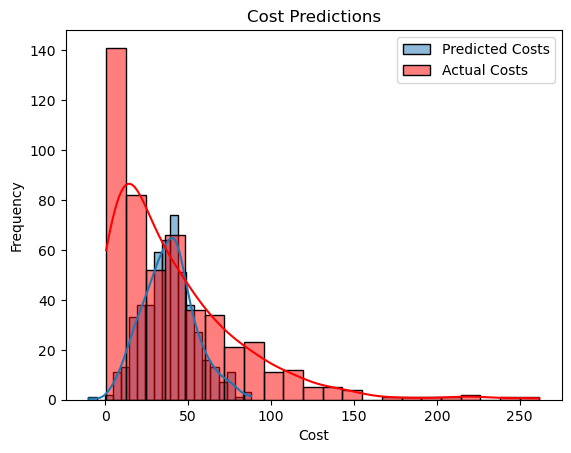

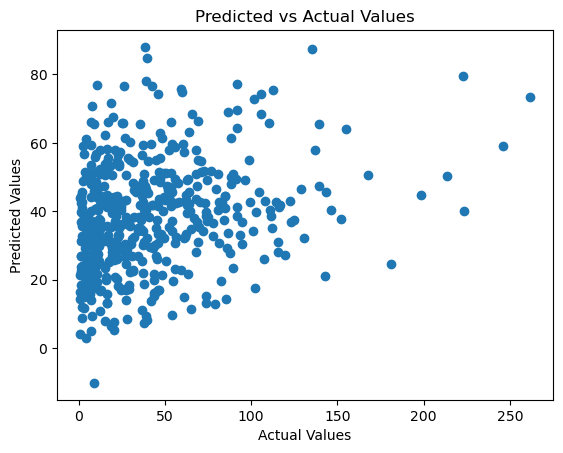

In [10]:
# for synthetic user data with actual values, plot actual vs predicted

# Call the function with save_plots=True
plot_predictions(predictions_df, actual_values, save_plots=True)

# Calling `predict()` directly...

In [11]:
from retrofit_cost_tool.predict import predict

In [13]:
# Define a function to handle button click
def on_button_click(b):
    file_path = list(file_uploader.value.keys())[0]
    with open(file_path, 'wb') as f:
        f.write(file_uploader.value[file_path]['content'])
    predict(file_path=file_path, model_name=model_selector.value)



In [14]:
# Link the button click to the on_button_click function
predict_button.on_click(on_button_click)

In [15]:
# Display the widgets
display(file_uploader)
display(model_selector)
display(predict_button)

FileUpload(value=(), accept='.csv', description='Upload data file')

Dropdown(description='Select model:', index=2, options=('ols', 'glm_gamma', 'ridge', 'elastic_net', 'random_fo…

Button(description='Make Predictions', style=ButtonStyle())